In [1]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn graphviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

In [3]:
dataset_path = "../Cleaned_Breast_Cancer.csv"
df = pd.read_csv(dataset_path)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          4024 non-null   int64  
 1   Grade                        4024 non-null   int64  
 2   Tumor Size                   4024 non-null   int64  
 3   Survival Months              4024 non-null   int64  
 4   Node Positive Ratio          4024 non-null   float64
 5   T Stage Encoded              4024 non-null   float64
 6   M Stage Encoded              4024 non-null   int64  
 7   N Stage Encoded              4024 non-null   float64
 8   Estrogen Status Encoded      4024 non-null   int64  
 9   Progesterone Status Encoded  4024 non-null   int64  
 10  Survival More Than 6 Years   4024 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 345.9 KB


In [70]:
X = df.drop(columns=["Survival Months", "Survival More Than 6 Years"])
y = df["Survival More Than 6 Years"]

In [71]:
class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch:
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._calculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _calculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparison (highest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, question, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=question[0], threshold=question[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

In [72]:
tree = DecisionTreeClassifierFromScratch(max_depth=3)
# tree = DecisionTreeClassifier(max_depth=3, criterion="gini")
tree.fit(X, y)
tree.draw_tree()

  (0) Is 6>=1.0?: gini:0.00
 ----- True branch :)
    (1) Is 7>=1.0?: gini:0.01
   ----- True branch :)
      (2) Is 3>=0.5806451612903226?: gini:0.00
     ----- True branch :)
        The predicted value --> 0.0
     ----- False branch :)
        The predicted value --> 1.0
   ----- False branch :)
      (2) Is 2>=59.0?: gini:0.03
     ----- True branch :)
        The predicted value --> 0.0
     ----- False branch :)
        The predicted value --> 0.0
 ----- False branch :)
    (1) Is 0>=41.0?: gini:0.00
   ----- True branch :)
      (2) Is 0>=48.0?: gini:0.00
     ----- True branch :)
        The predicted value --> 1.0
     ----- False branch :)
        The predicted value --> 1.0
   ----- False branch :)
      (2) Is 2>=22.0?: gini:0.02
     ----- True branch :)
        The predicted value --> 0.0
     ----- False branch :)
        The predicted value --> 1.0


In [73]:
from sklearn.metrics import accuracy_score
y_t_pred = tree.predict(X)
accuracy_score(y, y_t_pred)

0.5472166998011928

In [74]:
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(max_depth=3)
# tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")
tree_sk.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [75]:
y_t_pred = tree_sk.predict(X)
accuracy_score(y, y_t_pred)

0.5472166998011928

## Tuning

In [ ]:
params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

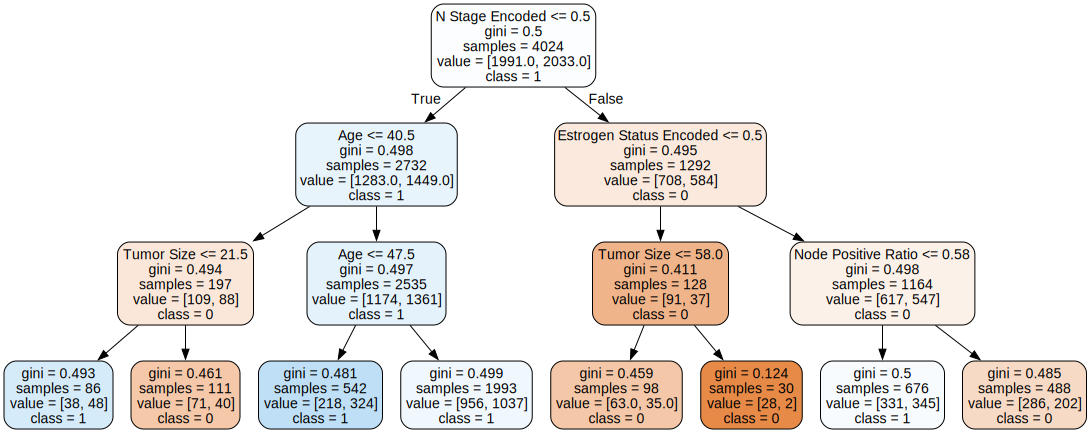

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source

import os
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree_images")
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
    tree_sk, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "breast_cancer.dot"),
    feature_names = X.columns.tolist(),
    class_names = y.unique().astype(str).tolist(),
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "breast_cancer.dot"))